In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, \
        math, os, sys, time

from itertools import repeat
from dataclasses import dataclass

from typing import *

In [2]:
df = pd.read_csv('new_everything.csv')

In [3]:
SENSORS = ['TP9', 'AF7', 'AF8', 'TP10']

In [4]:
# # Smooth df
# l = 50

# data = df[SENSORS].to_numpy().T

# sides = np.ones((50,)) / 200

# kernel = np.concat([sides, np.array([0.5]), sides])

# smoothed = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=data)

# df[SENSORS] = smoothed.T

In [5]:
def rolling_stats(data, window_size, min_std: float = 10.0):
    global max_std_ever
    
    kernel = np.ones(window_size) / window_size
    
    # Calculate rolling mean
    mean = np.convolve(data, kernel, mode='same')
    
    # Calculate rolling std
    data_squared = data ** 2
    mean_squared = np.convolve(data_squared, kernel, mode='same')
    std = np.sqrt(mean_squared - mean ** 2)

    std[std < min_std] = min_std

    return mean, std

In [6]:
def plot_sensors(
    data: pd.DataFrame, 
    r: slice = slice(0, -1), 
    history_len: int = 200, 
    trigger_stds: float = 1.75, 
    min_trigger_len: int = 5, 
    min_stretch_gap: int = 10,
    show_annotations: bool = True,
    show_highlights: bool = True,
    show_event_highlights: bool = True,
    show_event_tags: bool = True,
) -> 'Axis':
    
    fig, axs = plt.subplots(len(SENSORS), 1, figsize=(12, 2.5 * len(SENSORS)))
    
    axs = axs.flatten()

    sensor_trigger_history = []

    # Generate trigger bounds
    for s in SENSORS:

        mean, std = rolling_stats(
                data[s].to_numpy()[r], window_size=history_len
            )

        sensor_trigger_history.append(
            (
                mean - std * trigger_stds, mean + std * trigger_stds
            )
        )

    # Adjust time stamps to zero
    ts = data['timestamps'][r] - data['timestamps'][r].min()
    
    # Color palette for different sensors
    colors = plt.cm.tab10(range(len(SENSORS)))
    
    for i, (s, sh, ax) in enumerate(zip(SENSORS, sensor_trigger_history, axs)):

        d = data[s][r]

        up_highlight = np.full_like(d, fill_value=np.nan)
        down_highlight = np.full_like(d, fill_value=np.nan)

        # Highlight sections outside of bounds
        min_b, max_b = sh

        up_highlight[max_b < d] = d[max_b < d]
        down_highlight[min_b > d] = d[min_b > d]
        
        ax.plot(
            ts,
            d,
            color=colors[i],
            linewidth=2,
            alpha=0.8
        )
        # Plot green highlights (optional)
        if show_highlights:
            ax.plot(ts, min_b, color='red', alpha=0.5, linestyle='--', linewidth=1)
            ax.plot(ts, max_b, color='blue', alpha=0.5, linestyle='--', linewidth=1)

            ax.plot(ts, up_highlight, color='green', linewidth=2.5)
            ax.plot(ts, down_highlight, color='green', linewidth=2.5)
        
        # Add annotations (optional)
        if show_annotations:
            # Find continuous stretches of non-NaN values
            def find_stretches(highlight_array, min_len, min_gap):
                """Find continuous stretches of non-NaN values >= min_len"""
                stretches = []
                start = None
                
                for i in range(len(highlight_array)):
                    if not np.isnan(highlight_array[i]):
                        if start is None:
                            start = i
                    else:
                        if start is not None:
                            length = i - start
                            if length >= min_len:
                                stretches.append((start, i - 1, length))
                            start = None
                
                # Handle case where stretch extends to end
                if start is not None:
                    length = len(highlight_array) - start
                    if length >= min_len:
                        stretches.append((start, len(highlight_array) - 1, length))
                
                # Filter out stretches that are too close together
                if len(stretches) <= 1:
                    return stretches
                
                filtered_stretches = [stretches[0]]
                for start_idx, end_idx, length in stretches[1:]:
                    prev_end = filtered_stretches[-1][1]
                    # Check if gap between previous stretch end and current stretch start is large enough
                    if start_idx - prev_end >= min_gap:
                        filtered_stretches.append((start_idx, end_idx, length))
                    else:
                        # Merge with previous stretch if too close
                        prev_start = filtered_stretches[-1][0]
                        new_length = end_idx - prev_start + 1
                        filtered_stretches[-1] = (prev_start, end_idx, new_length)
                
                return filtered_stretches
            
            # Add tags for upper threshold violations
            up_stretches = find_stretches(up_highlight, min_trigger_len, min_stretch_gap)
            for start_idx, end_idx, length in up_stretches:
                ax.text(
                    ts.iloc[start_idx], 
                    d.iloc[start_idx],
                    f'▲ HIGH ({length})',
                    fontsize=9,
                    fontweight='bold',
                    color='darkred',
                    ha='left',
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8)
                )
            
            # Add tags for lower threshold violations
            down_stretches = find_stretches(down_highlight, min_trigger_len, min_stretch_gap)
            for start_idx, end_idx, length in down_stretches:
                ax.text(
                    ts.iloc[start_idx],
                    d.iloc[start_idx],
                    f'▼ LOW ({length})',
                    fontsize=9,
                    fontweight='bold',
                    color='darkblue',
                    ha='left',
                    va='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=0.8)
                )

        # Styling
        ax.set_ylabel(s, fontsize=11, fontweight='bold')
        ax.set_xlabel('Time (s)' if i == len(SENSORS) - 1 else '', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Format x-axis for better readability
        ax.tick_params(axis='both', labelsize=9)
        
    plt.suptitle('Sensor Data with Anomaly Detection', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return axs

def plot_deltas(
        data: pd.DataFrame,
        r: slice = slice(0, -1),
        prev_n: int = 10,
        **kwargs,
    ) -> 'Axis':

    channels = data[SENSORS].to_numpy()

    # get deltas, -mean prev_n
    kernel = -np.ones((prev_n)) / prev_n

    # Add self as 1
    kernel = np.pad(kernel, (0, 1), mode='constant', constant_values=1)

    kernel = np.pad(kernel, (0, prev_n), mode='constant', constant_values=0)

    values = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), 
                              axis=0, arr=channels)

    new_df = df.copy()

    new_df[SENSORS] = values

    axs = plot_sensors(new_df, r=r, **kwargs)

    return axs

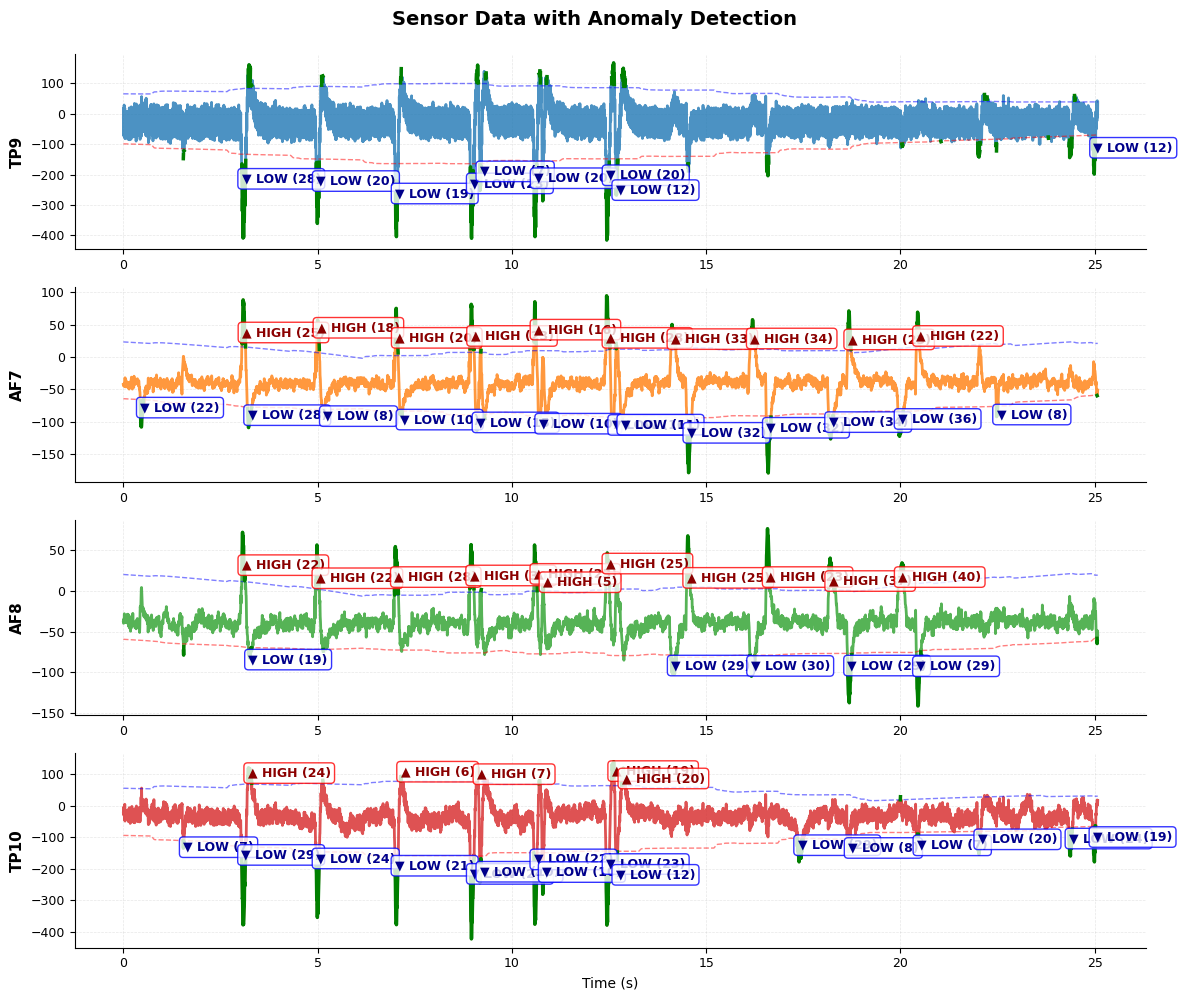

In [7]:
start: int = 0
bound: int = len(df)

axs = plot_sensors(df, r=slice(start, start + bound), history_len=bound // 2, show_annotations=True, show_highlights=True)

In [8]:
lt_m = 40
st_m = 20

green_l = 30
green_s = 15

LARGE_TRIGGERS = {
    'TP9' : (-85, 85),
    'AF7' : (-lt_m, lt_m),
    'AF8' : (-green_l, green_l),
    'TP10' : (-85, 85),
}

SMALL_TRIGGERS = {
    'TP9' : (-60, 60),
    'AF7' : (-st_m, st_m),
    'AF8' : (-green_s, green_s),
    'TP10' : (-60, 60),
}

# To detect static
BOUNDS = {
    'TP9' : (-500, 500),
    'AF7' : (-500, 500),
    'AF8' : (-500, 500),
    'TP10' : (-500, 500),
}

@dataclass
class EventInProgress:

    start: float
    
    sensor: str

    location: Literal['positive', 'negative']
    level: Literal['small', 'large', 'static']

    # Count so can have some limit
    interupts: int

    # In frames so we can track
    current_length: int

@dataclass
class CompletedEvent:

    start: float
    end: float
    total_time: float

    sensor: str

    location: Literal['positive', 'negative']
    level: Literal['small', 'large', 'static']

    # In frames so we can track
    frame_length: int

    def __str__(self) -> str:

        return f'{self.sensor} - {self.level} {self.location}'

@dataclass
class SensorCurrent:

    sensor: str
    value: float

@dataclass
class EmittedEvent:
    name: str
    time: float

    is_event: bool = True

def handle_event_snapshot(current: List[SensorCurrent], events: List[EventInProgress], means: np.ndarray, timestamp: float, max_interupts: int = 0, min_frames_for_complete: int = 5) -> Tuple[List[EventInProgress], List[CompletedEvent]]:
    
    completed_events = []
    continuing_events = []

    for i, s in enumerate(SENSORS):

        # Get cutoffs

        STATIC_CUTOFF_LOW, STATIC_CUTOFF_HIGH = BOUNDS[s]
        LARGE_CUTOFF_LOW, LARGE_CUTOFF_HIGH = LARGE_TRIGGERS[s]
        SMALL_CUTOFF_LOW, SMALL_CUTOFF_HIGH = SMALL_TRIGGERS[s]

        sensor_value = [c for c in current if c.sensor == s][0].value - means[i].item()

        relivant_event = [e for e in events if e.sensor == s]

        # Should only have one event per sensor at a time
        assert (ls := len(relivant_event)) <= 1, f'Events on sensor {s} has length {ls}, can only have 0 or 1'

        relivant_event = None if len(relivant_event) == 0 else relivant_event[0]

        # Increase length
        if relivant_event is not None:

            relivant_event.current_length += 1

        new_event = None

        # Check if staticing
        if not (STATIC_CUTOFF_LOW < sensor_value < STATIC_CUTOFF_HIGH):

            new_event = EventInProgress(
                start=timestamp,
                sensor=s,
                location='positive' if sensor_value > STATIC_CUTOFF_HIGH else 'negative',
                level='static',
                interupts=0,
                current_length=1,
            )

        elif not (LARGE_CUTOFF_LOW < sensor_value < LARGE_CUTOFF_HIGH):

            new_event = EventInProgress(
                start=timestamp,
                sensor=s,
                location='positive' if sensor_value > LARGE_CUTOFF_HIGH else 'negative',
                level='large',
                interupts=0,
                current_length=1,
            )

        elif not (SMALL_CUTOFF_LOW < sensor_value < SMALL_CUTOFF_HIGH):

            new_event = EventInProgress(
                start=timestamp,
                sensor=s,
                location='positive' if sensor_value > SMALL_CUTOFF_HIGH else 'negative',
                level='small',
                interupts=0,
                current_length=1,
            )

        # If both are none then do nothing
        if relivant_event is None and new_event is None:
            continue
        
        elif relivant_event is None and new_event is not None:

            # Add new event where there was none
            continuing_events.append(new_event)

        elif relivant_event is not None and (new_event is None or (new_event.location != relivant_event.location or new_event.level != relivant_event.level)):
            # Have previous event and handle new one

            # If its not same (small -> large & large -> small == same)
            if new_event is None or (new_event.level == 'static' and relivant_event.level != 'static') \
                or (new_event.location != relivant_event.location):

                relivant_event.interupts += 1

            # small -> large change to large
            elif new_event.level == 'large' and relivant_event.level == 'small':

                relivant_event.level = 'large'

        # Handle completing event
        if relivant_event is not None:

            if relivant_event.interupts > max_interupts:

                if (relivant_event.current_length - relivant_event.interupts) >= min_frames_for_complete:

                    comp_event = CompletedEvent(
                        start=relivant_event.start,
                        end=timestamp,
                        total_time=timestamp - relivant_event.start,
                        sensor=relivant_event.sensor,
                        location=relivant_event.location,
                        level=relivant_event.level,
                        frame_length=relivant_event.current_length,
                    )

                    completed_events.append(comp_event)
                
                if new_event is not None:

                    continuing_events.append(new_event)

            else:

                continuing_events.append(relivant_event)

    return (continuing_events, completed_events)

recent_events_tracker = []

def get_count_peaks(
        recent_events: List,
        sensor: str,
        level: Literal['static', 'large', 'small'] = None, 
        location: Literal['positive', 'negative'] = None,
    ) -> int:

    new_list = []

    for re in recent_events:

        if not sensor == re.sensor:
            continue

        if level is not None and not level == re.level:
            continue

        if location is not None and not location == re.location:
            continue

        new_list.append(re)

    return len(new_list)

def frame_manager(df: pd.DataFrame, emitted_events, buffer_size: int = 1000,  lag_encounter: float = 0.3, search_zone: float = 0.7) -> List[CompletedEvent]:

    completed_events_buffer = []
    continuing_events = []

    np_df = df[SENSORS].to_numpy().T

    min_ts = df['timestamps'].min()

    last_key_bind = min_ts

    use_non_event = False
    fo = 50

    means_store = np.zeros((4, len(df)))

    for i, (_, row) in enumerate(df.iterrows()):

        ts = row['timestamps']
        
        slce = slice(max(i - buffer_size, 0), i)

        means = np_df[:, slce].mean(axis=1)

        means_store[:, i] = means

        sv = [SensorCurrent(s, v) for s, v in zip(SENSORS, row[SENSORS].tolist())]

        continuing_events, compe = handle_event_snapshot(sv, continuing_events, means, ts)

        completed_events_buffer.extend(compe)

        # Get all recent in buffer, do not delete here
        recent_events = [e for e in completed_events_buffer if ts - e.end < search_zone]

        completed_events_buffer = recent_events.copy()

        recent_events_tracker.append(len(recent_events))

        event_latency_trigger = any([lag_encounter < ts - re.end < search_zone for re in recent_events])
        with_in_timeout = ts - last_key_bind < search_zone


        # Only trigger if there is a recent event between 0.4 and 0.5 seconds ago and its been 0.5 seconds since the last key binding
        if not event_latency_trigger or with_in_timeout:

            continue

        # Look for events

        blue_count_negative_l = get_count_peaks(recent_events, 'TP9', level='large', location='negative')
        red_count_negative_l = get_count_peaks(recent_events, 'TP10', level='large', location='negative')
        blue_count_negative = get_count_peaks(recent_events, 'TP9', location='negative')
        red_count_negative = get_count_peaks(recent_events, 'TP10', location='negative')
        blue_count_positive_l = get_count_peaks(recent_events, 'TP9', level='large', location='positive')
        red_count_positive_l = get_count_peaks(recent_events, 'TP10', level='large', location='positive')

        orange_count_positive_l = get_count_peaks(recent_events, 'AF7', level='large', location='positive')
        orange_count_negative_l = get_count_peaks(recent_events, 'AF7', level='large', location='negative')
        orange_count_positive_s = get_count_peaks(recent_events, 'AF7', level='small', location='positive')
        orange_count_negative_s = get_count_peaks(recent_events, 'AF7', level='small', location='negative')

        green_count_positive_l = get_count_peaks(recent_events, 'AF8', level='large', location='positive')
        green_count_positive_s = get_count_peaks(recent_events, 'AF8', level='small', location='positive')
        green_count_negative_l = get_count_peaks(recent_events, 'AF8', level='large', location='negative')
        green_count_negative_s = get_count_peaks(recent_events, 'AF8', level='small', location='negative')

        event = None
        
        # Double Blink
        if (blue_count_negative >= 2 or red_count_negative >= 2) or (blue_count_negative_l == 1 and blue_count_positive_l == 1 and red_count_negative_l == 1 and red_count_positive_l == 1):

            event = EmittedEvent(
                name='Double Blink',
                time=ts - min_ts,
            )
        
        # Single Blink
        elif (blue_count_negative_l == 1 and red_count_negative_l == 1):

            event = EmittedEvent(
                name='Single Blink',
                time=ts - min_ts,

            )

        # else using orange
        elif (orange_count_negative_l) and (orange_count_positive_l):

            # if orange up before orange down its a left else right
            orange_up = [re for re in recent_events if re.level == 'large' and re.sensor == 'AF7' and re.location == 'positive'][0]
            orange_down = [re for re in recent_events if re.level == 'large' and re.sensor == 'AF7' and re.location == 'negative'][0]

            if orange_down.end > orange_up.end:

                event = EmittedEvent(
                    name='Left Look',
                    time=ts - min_ts,
                )

            else:

                event = EmittedEvent(
                    name='Right Look',
                    time=ts - min_ts,
                )

                # check with direction with green
        # elif (green_count_negative_l) and (green_count_positive_l):

        #     # if orange up before orange down its a left else right
        #     green_up = [re for re in recent_events if re.level == 'large' and re.sensor == 'AF8' and re.location == 'positive'][0]
        #     green_down = [re for re in recent_events if re.level == 'large' and re.sensor == 'AF8' and re.location == 'negative'][0]

        #     if green_down.end < green_up.end:

        #         event = EmittedEvent(
        #             name='Left Look',
        #             time=ts - min_ts,
        #         )

        #     else:

        #         event = EmittedEvent(
        #             name='Right Look',
        #             time=ts - min_ts,
        #         )

        else:

            use_non_event = True
                
            if not use_non_event and fo == 0:

                use_non_event = True

                event = event = EmittedEvent(
                    name='\n'.join([str(e) for e in recent_events]),
                    time=ts - min_ts,
                    is_event=False,
                )
            else:
                fo -= 1

        if event is not None and event.is_event:

            print([str(re) for re in recent_events], event.name)
            recent_events = []


            use_non_event = False
            fo = 100

            # If we do an event update key bindings
            last_key_bind = ts

            # print([str(e) for e in recent_events], event, sep='\n')

        if event: emitted_events.append(event)

        with open('events_log.txt', 'a') as log:

            print(' '.join([str(ts)] + [str(e) for e in recent_events]), file=log)


    return completed_events_buffer, emitted_events, means_store

In [9]:
emitted_events = []

In [10]:
events, emitted_events, means_store = frame_manager(df, emitted_events)

C:\Users\Theon\AppData\Local\Temp\ipykernel_26668\301642291.py:240: RuntimeWarning: Mean of empty slice.
  means = np_df[:, slce].mean(axis=1)
c:\Users\Theon\Downloads\hackharvard-muse-backend\.venv\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


['TP9 - large negative', 'AF7 - large positive', 'TP10 - large negative', 'AF8 - large positive', 'TP9 - large positive', 'TP10 - large positive', 'TP9 - large positive', 'AF7 - large negative', 'AF8 - large negative'] Single Blink
['TP9 - large negative', 'TP10 - large negative', 'AF7 - large positive', 'AF8 - large positive', 'TP9 - large positive', 'TP10 - large positive', 'AF7 - large negative', 'AF8 - large negative', 'AF7 - small negative'] Double Blink
['TP9 - large negative', 'TP10 - large negative', 'AF7 - large positive', 'AF8 - large positive', 'TP9 - large positive', 'TP10 - large positive', 'AF8 - large negative', 'AF7 - large negative', 'AF8 - small negative', 'AF8 - small negative'] Double Blink
['TP9 - large negative', 'TP10 - large negative', 'AF8 - large positive', 'AF7 - large positive', 'AF8 - small negative', 'AF8 - large negative', 'TP9 - large positive', 'AF7 - large negative', 'TP10 - large positive', 'TP9 - large negative', 'AF7 - large positive', 'TP10 - large

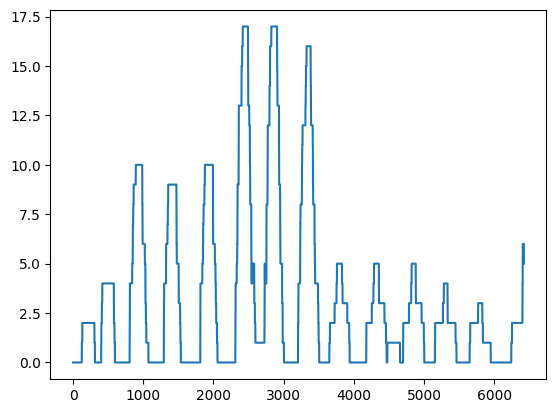

In [11]:
plt.plot(recent_events_tracker)

In [12]:
len(emitted_events)

13

In [13]:
emitted_events

[EmittedEvent(name='Single Blink', time=np.float64(3.4570000171661377), is_event=True),
 EmittedEvent(name='Double Blink', time=np.float64(5.351999998092651), is_event=True),
 EmittedEvent(name='Double Blink', time=np.float64(7.383000135421753), is_event=True),
 EmittedEvent(name='Double Blink', time=np.float64(9.332000017166138), is_event=True),
 EmittedEvent(name='Single Blink', time=np.float64(10.660000085830688), is_event=True),
 EmittedEvent(name='Single Blink', time=np.float64(11.36300015449524), is_event=True),
 EmittedEvent(name='Double Blink', time=np.float64(12.815999984741211), is_event=True),
 EmittedEvent(name='Left Look', time=np.float64(14.67900013923645), is_event=True),
 EmittedEvent(name='Left Look', time=np.float64(16.73800015449524), is_event=True),
 EmittedEvent(name='Right Look', time=np.float64(18.831000089645386), is_event=True),
 EmittedEvent(name='Right Look', time=np.float64(20.569000005722046), is_event=True),
 EmittedEvent(name='Left Look', time=np.float64(

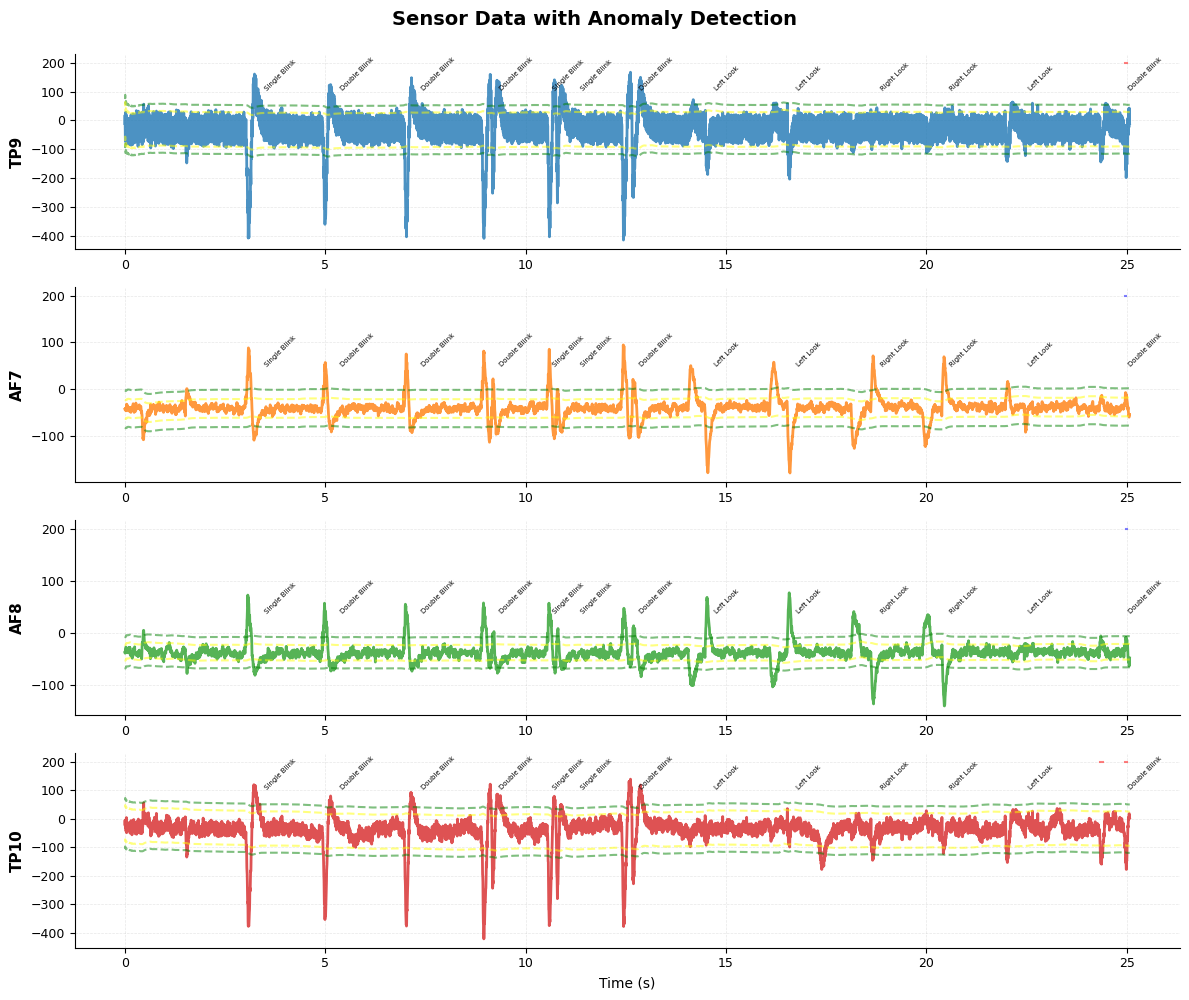

In [14]:
start: int = 0
bound: int = len(df) - 1

r = slice(start, start + bound)
min_ts = df['timestamps'][r].min()
max_ts = df['timestamps'][r].max()

atime = df['timestamps'] - min_ts

axs = plot_sensors(df, r=r, history_len=bound // 2, show_annotations=False, show_highlights=False)
for (s, ax, m) in zip(SENSORS, axs, means_store):

    # Add events
    sensor_events = [e for e in events if e.sensor == s and e.start > min_ts and e.end < df['timestamps'].iloc[start + bound]]

    for ee in emitted_events:

        ts = ee.time

        if 0 < ts < max_ts - min_ts:

            ax.text(ts, LARGE_TRIGGERS[s][1] * 1.2, ee.name, fontsize=5, rotation=45)

    for se in sensor_events:

        ax.plot(np.linspace(se.start - min_ts, se.end - min_ts, 200), list(repeat(200, times=200)), color='red' if se.level == 'large' else 'blue', alpha=0.5)

    for b in LARGE_TRIGGERS[s]:
        ax.plot(atime, m + b, color='green', linestyle='--', alpha=0.5)
    for b in SMALL_TRIGGERS[s]:
        ax.plot(atime, m + b, color='yellow', linestyle='--', alpha=0.5)

    # for b in BOUNDS[s]:

    #     ax.plot(df['timestamps'][r] - df['timestamps'][r].min(), list(repeat(b, times=len(df))), color='red')


In [15]:
fig = axs[0].get_figure()
fig.savefig('sensor_plot.png', dpi=300, bbox_inches='tight')